In [71]:
import pyspark
import pyspark.pandas
import copyData
import config
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
import pmdarima as pm

# Starting Spark session

In [23]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()

# Reading sentiment data from mongodb

In [42]:
df = ( spark.read
		.format('mongodb')
		.option('database'      , f'{config.MongoDb.database}')
		.option('collection'    , f'{config.MongoDb.collection}')
		.option('connection.uri', f'mongodb://{config.MongoDb.user}:{config.MongoDb.password}@{config.MongoDb.host}:{config.MongoDb.port}')
		.load()
)
df.printSchema()

root
 |-- _id: string (nullable = true)
 |-- compound: double (nullable = true)
 |-- createdAt: timestamp (nullable = true)
 |-- negative: double (nullable = true)
 |-- neutral: double (nullable = true)
 |-- positive: double (nullable = true)
 |-- userName: string (nullable = true)



# Performing EDA

## checking the earliest and the latest tweet dates

In [43]:
df.select(
    pyspark.sql.functions.min('createdAt'),
    pyspark.sql.functions.max('createdAt')
).show()

+-------------------+-------------------+
|     min(createdAt)|     max(createdAt)|
+-------------------+-------------------+
|2009-04-06 22:19:45|2009-06-25 10:28:31|
+-------------------+-------------------+



## Exploding the 'createdAt' timestamp into it's parts, for time series analysis

In [45]:
df1 = df.select(
    '*',
    pyspark.sql.functions.year     ('createdAt').alias('year'     ),
    pyspark.sql.functions.month    ('createdAt').alias('month'    ),
    pyspark.sql.functions.day      ('createdAt').alias('month-day'),
    pyspark.sql.functions.dayofweek('createdAt').alias('week-day' ),
    pyspark.sql.functions.hour     ('createdAt').alias('hour'     ),
    pyspark.sql.functions.minute   ('createdAt').alias('minute'   ),
    pyspark.sql.functions.second   ('createdAt').alias('second'   ),
)
# df = df.drop('createdAt', 'userName')
df1.show(10)

+--------------------+--------------------+-------------------+-------------------+------------------+-------------------+---------------+----+-----+---------+--------+----+------+------+
|                 _id|            compound|          createdAt|           negative|           neutral|           positive|       userName|year|month|month-day|week-day|hour|minute|second|
+--------------------+--------------------+-------------------+-------------------+------------------+-------------------+---------------+----+-----+---------+--------+----+------+------+
|664a17e4a9497c29d...|-0.01730000041425228|2009-04-06 22:19:45|0.11699999868869781|0.7680000066757202|0.11400000005960464|_TheSpecialOne_|2009|    4|        6|       2|  22|    19|    45|
|664a17e4a9497c29d...|               -0.75|2009-04-06 22:19:49|0.29100000858306885|0.7089999914169312|                0.0|  scotthamilton|2009|    4|        6|       2|  22|    19|    49|
|664a17e4a9497c29d...| 0.49390000104904175|2009-04-06 22:19:

## calculating coorelation between features

In [46]:
df2 = pyspark.pandas.DataFrame(df1)

/usr/local/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


<Axes: >

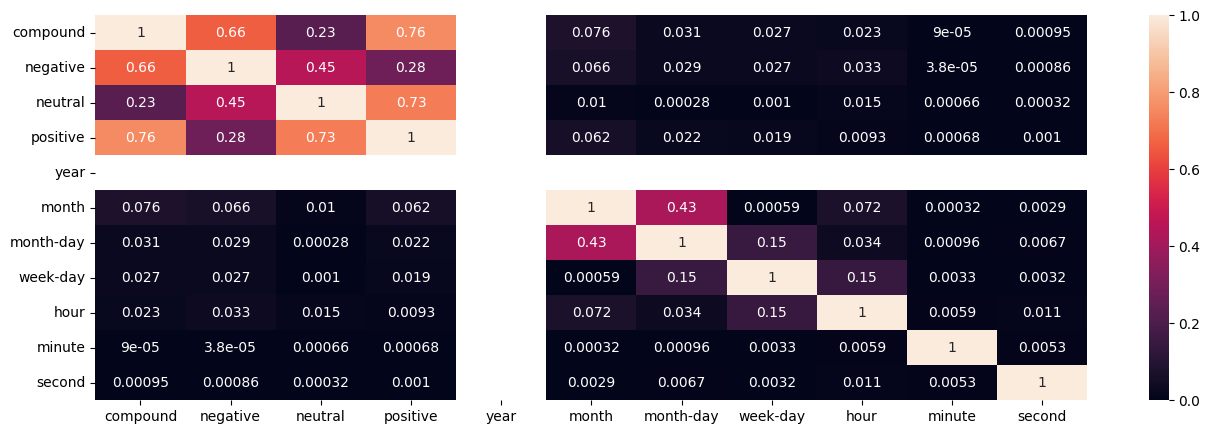

In [47]:
corelation = df2.drop(columns= ['_id', 'createdAt']).corr().to_pandas()
plt.figure(figsize = (16,5))
seaborn.heatmap(corelation.abs(), annot= True, vmin= 0, vmax= 1)

# plotting average sentiment scores over different time-frames

/usr/local/lib/python3.12/site-packages/pyspark/pandas/groupby.py:649: FutureWarning: Default value of `numeric_only` will be changed to `False` instead of `True` in 4.0.0.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


<Axes: xlabel='year,month,month-day'>

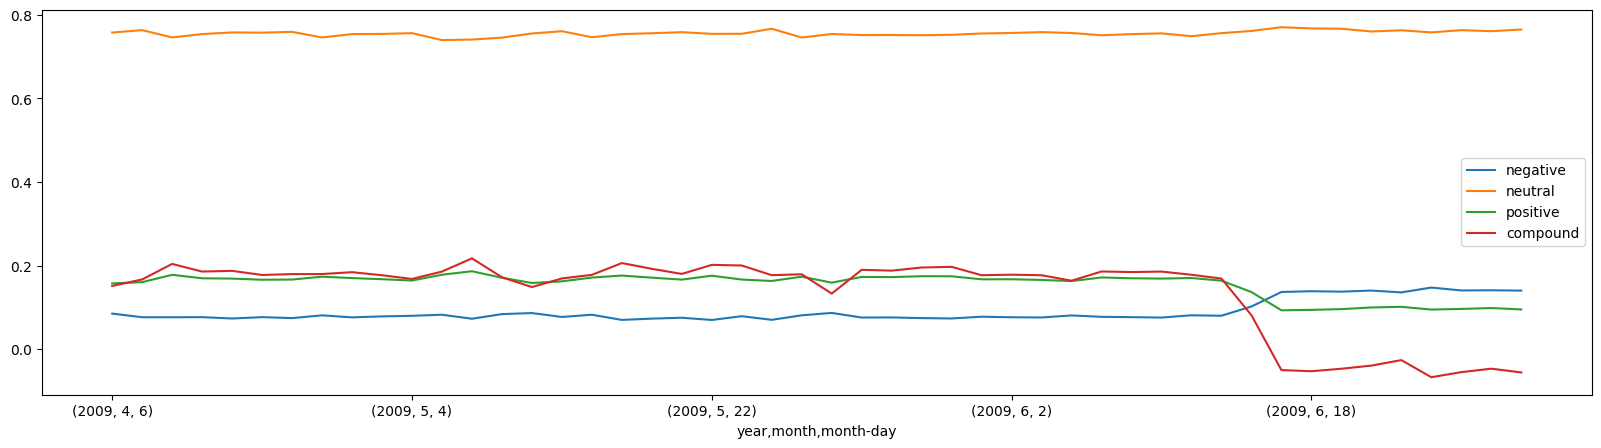

In [178]:
( df2.groupby(['year', 'month', 'month-day'])
# ( df2.groupby(df2['createdAt'].dt.day)
    .mean()
    [['negative','neutral','positive', 'compound']]
    .sort_index()
    .to_pandas()
    .plot(figsize= (20, 5))
)

/usr/local/lib/python3.12/site-packages/pyspark/pandas/groupby.py:649: FutureWarning: Default value of `numeric_only` will be changed to `False` instead of `True` in 4.0.0.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


<Axes: xlabel='month-day'>

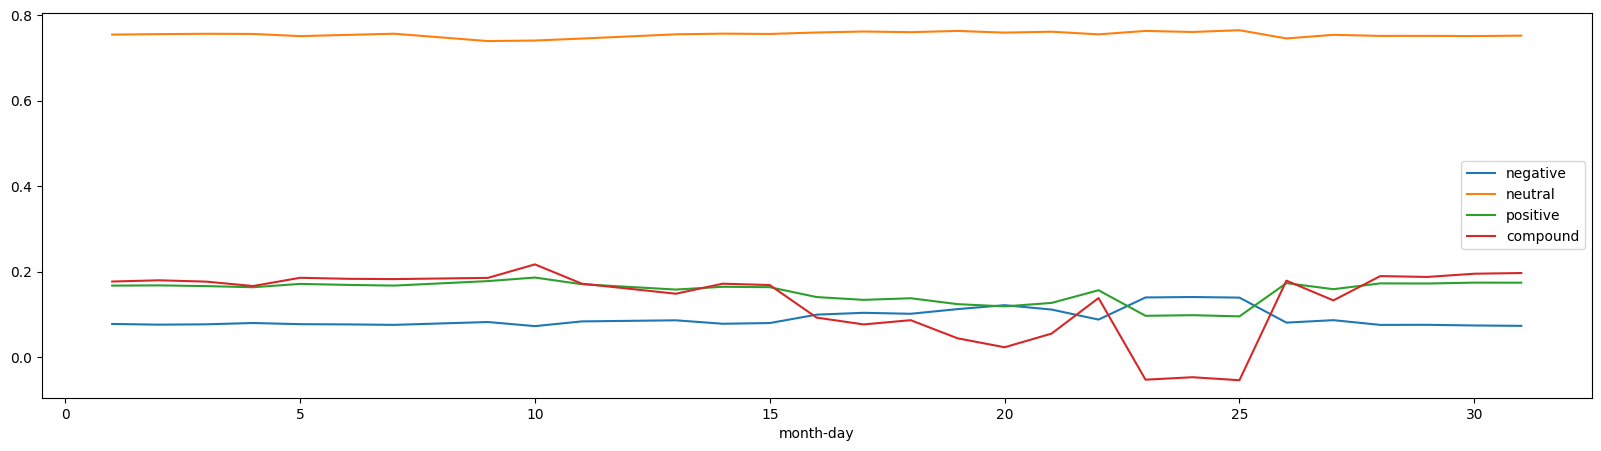

In [179]:
( df2.groupby('month-day')
    .mean()
    [['negative','neutral','positive', 'compound']]
    .sort_index()
    .to_pandas()
    .plot(figsize= (20, 5))
)

/usr/local/lib/python3.12/site-packages/pyspark/pandas/groupby.py:649: FutureWarning: Default value of `numeric_only` will be changed to `False` instead of `True` in 4.0.0.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


<Axes: xlabel='week-day'>

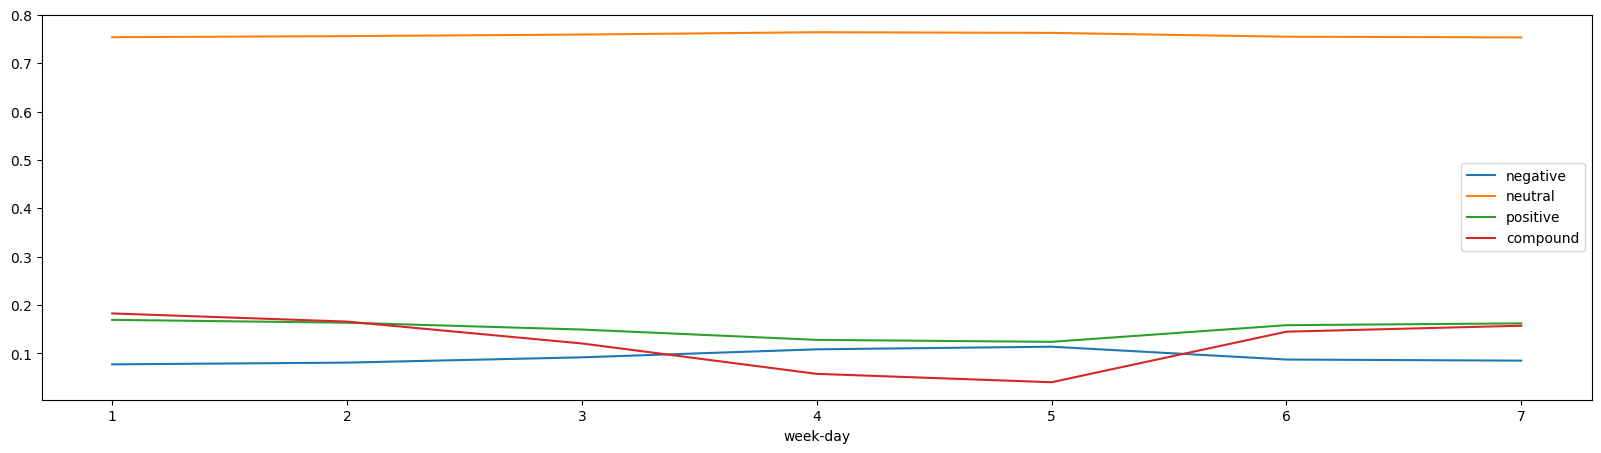

In [180]:
# ( df.groupBy('week-day')
( df2.groupby('week-day')
    .mean()
    [['negative','neutral','positive', 'compound']]
    .sort_index()
    .to_pandas()
    .plot(figsize= (20, 5))
)

/usr/local/lib/python3.12/site-packages/pyspark/pandas/groupby.py:649: FutureWarning: Default value of `numeric_only` will be changed to `False` instead of `True` in 4.0.0.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


<Axes: xlabel='hour'>

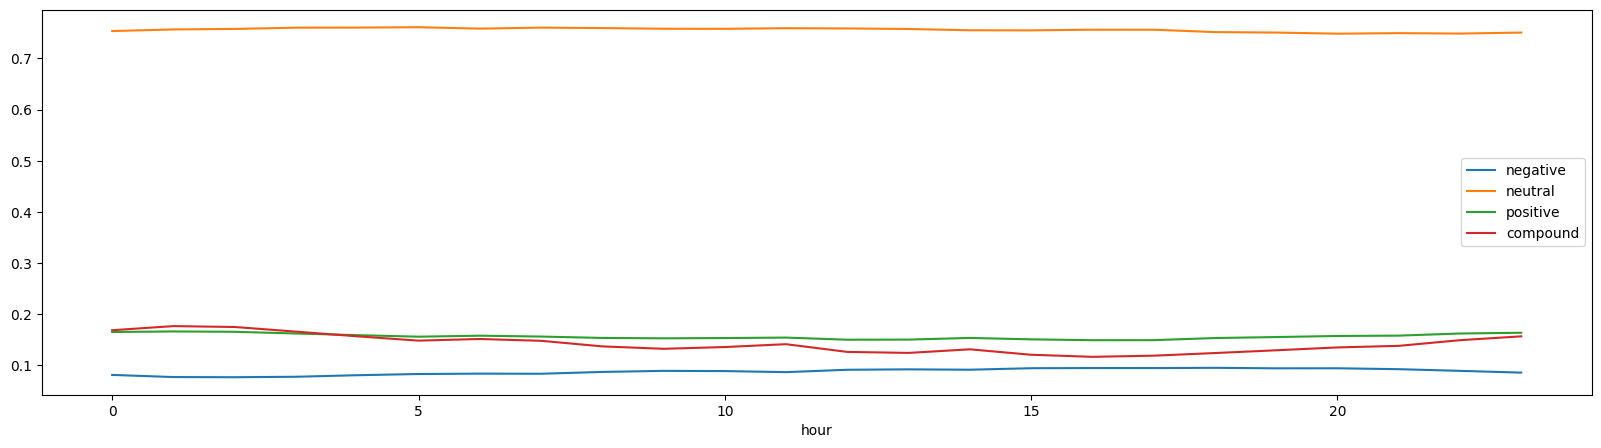

In [181]:
# ( df.groupBy('hour')
( df2.groupby('hour')
    .mean()
    [['negative','neutral','positive', 'compound']]
    .sort_index()
    .to_pandas()
    .plot(figsize= (20, 5))
)

# Training a time series ARIMA model to predict future sentiments

In [49]:
df3 = ( df.withColumn(
        'createdAt',
        pyspark.sql.functions.date_trunc('hour', 'createdAt')
    )
    .groupBy('createdAt')
    .mean()
    .orderBy('createdAt')
)

## defing the train and predict functions

In [158]:
from statsmodels.tsa.stattools import adfuller

inMemDf = df3.toPandas().set_index('createdAt')

def train(df):
    return {
        colName: pm.auto_arima(
            df[colName],
            X= df, 
            d= 2, 
            error_action= 'ignore', 
            trace=True,
            suppress_warnings=True, 
            maxiter=500,
            m=4,
            stationary=False,
            test='adf'
        )

        for colName in df.columns
    }

def predict(models, days, df):
    n_periods = days * 24

    prediction = pd.DataFrame({
        'predicted '+ colName: model.predict(
            n_periods= n_periods, 
            X        = df[-n_periods:], 
            alpha    = 0.05
        )
        for colName, model in models.items()
    })
    prediction = prediction.set_index(
        pd.date_range(
            start  = inMemDf.index.max(),
            periods= prediction.shape[0],
            freq   = 'h'
        )
    )
    return pd.concat([df, prediction])

## training

In [77]:
models = train(inMemDf)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=-12269.743, Time=1.94 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=-12511.247, Time=0.20 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=-12508.117, Time=0.41 sec


/usr/local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1905: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.12/site-packages/pmdarima/arima/_auto_solvers.py:40: RuntimeWarning: invalid value encountered in divide
  max_invroot = max(0, *np.abs(1 / model.maroots()))


 ARIMA(0,2,1)(0,0,1)[4]             : AIC=-12507.247, Time=0.36 sec
 ARIMA(0,2,0)(1,0,0)[4]             : AIC=-12509.247, Time=0.26 sec
 ARIMA(0,2,0)(0,0,1)[4]             : AIC=-12509.247, Time=0.27 sec
 ARIMA(0,2,0)(1,0,1)[4]             : AIC=-12507.247, Time=0.35 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=-12510.128, Time=0.25 sec


/usr/local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1905: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,2,1)(0,0,0)[4]             : AIC=-12509.247, Time=0.23 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=-12264.260, Time=1.32 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=-12988.633, Time=0.37 sec
 ARIMA(0,2,0)(1,0,0)[4] intercept   : AIC=-12986.705, Time=0.60 sec
 ARIMA(0,2,0)(0,0,1)[4] intercept   : AIC=-12979.423, Time=0.58 sec
 ARIMA(0,2,0)(1,0,1)[4] intercept   : AIC=-13001.136, Time=0.69 sec
 ARIMA(0,2,0)(2,0,1)[4] intercept   : AIC=-13001.121, Time=0.97 sec
 ARIMA(0,2,0)(1,0,2)[4] intercept   : AIC=-12845.604, Time=1.59 sec
 ARIMA(0,2,0)(0,0,2)[4] intercept   : AIC=-12839.565, Time=1.41 sec
 ARIMA(0,2,0)(2,0,0)[4] intercept   : AIC=-12985.402, Time=0.85 sec
 ARIMA(0,2,0)(2,0,2)[4] intercept   : AIC=-12905.584, Time=1.23 sec
 ARIMA(1,2,0)(1,0,1)[4] intercept   : AIC=-12999.136, Time=0.83 sec
 ARIMA(0,2,1)(1,0,1)[4] intercept   : AIC=-12999.136, Time=0.75 sec
 ARIMA(1,2,1)(1,0,1)[4] intercept   : AIC=-12997.136, Time=0.85 sec

Best model:  ARIMA(0,2,0)(1,0,1)[4] intercept
T

/usr/local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1905: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.12/site-packages/pmdarima/arima/_auto_solvers.py:40: RuntimeWarning: invalid value encountered in divide
  max_invroot = max(0, *np.abs(1 / model.maroots()))


 ARIMA(0,2,1)(0,0,1)[4]             : AIC=-12507.247, Time=0.34 sec
 ARIMA(0,2,0)(1,0,0)[4]             : AIC=-12509.247, Time=0.26 sec
 ARIMA(0,2,0)(0,0,1)[4]             : AIC=-12509.247, Time=0.29 sec
 ARIMA(0,2,0)(1,0,1)[4]             : AIC=-12507.247, Time=0.33 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=-11548.568, Time=0.70 sec


/usr/local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1905: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,2,1)(0,0,0)[4]             : AIC=-12509.247, Time=0.22 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=-11560.854, Time=0.74 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=-12988.633, Time=0.36 sec
 ARIMA(0,2,0)(1,0,0)[4] intercept   : AIC=-12986.477, Time=0.52 sec
 ARIMA(0,2,0)(0,0,1)[4] intercept   : AIC=-12985.207, Time=0.56 sec
 ARIMA(0,2,0)(1,0,1)[4] intercept   : AIC=-12949.157, Time=0.77 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=-12986.633, Time=0.42 sec
 ARIMA(0,2,1)(0,0,0)[4] intercept   : AIC=-12986.633, Time=0.41 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=-12984.633, Time=0.46 sec

Best model:  ARIMA(0,2,0)(0,0,0)[4] intercept
Total fit time: 9.759 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=-12224.437, Time=2.10 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=-12511.247, Time=0.19 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=-9119.727, Time=1.78 sec


/usr/local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1905: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.12/site-packages/pmdarima/arima/_auto_solvers.py:40: RuntimeWarning: invalid value encountered in divide
  max_invroot = max(0, *np.abs(1 / model.maroots()))


 ARIMA(0,2,1)(0,0,1)[4]             : AIC=-12507.241, Time=0.31 sec
 ARIMA(0,2,0)(1,0,0)[4]             : AIC=-12509.247, Time=0.25 sec
 ARIMA(0,2,0)(0,0,1)[4]             : AIC=-12509.241, Time=0.33 sec
 ARIMA(0,2,0)(1,0,1)[4]             : AIC=-12507.241, Time=0.36 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=-13191.689, Time=0.91 sec
 ARIMA(1,2,0)(0,0,1)[4]             : AIC=-11450.785, Time=1.32 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=-11486.575, Time=1.40 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=-12203.990, Time=0.79 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=-12026.362, Time=0.81 sec


/usr/local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1905: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,2,1)(0,0,0)[4]             : AIC=-12509.247, Time=0.21 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=-12317.700, Time=1.45 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=-12986.633, Time=0.41 sec

Best model:  ARIMA(1,2,0)(0,0,0)[4]          
Total fit time: 12.640 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=inf, Time=2.74 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=-12511.247, Time=0.18 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=-10526.829, Time=0.62 sec


/usr/local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1905: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.12/site-packages/pmdarima/arima/_auto_solvers.py:40: RuntimeWarning: invalid value encountered in divide
  max_invroot = max(0, *np.abs(1 / model.maroots()))


 ARIMA(0,2,1)(0,0,1)[4]             : AIC=-12507.247, Time=0.35 sec
 ARIMA(0,2,0)(1,0,0)[4]             : AIC=-12509.247, Time=0.25 sec
 ARIMA(0,2,0)(0,0,1)[4]             : AIC=-12509.247, Time=0.27 sec
 ARIMA(0,2,0)(1,0,1)[4]             : AIC=-12507.247, Time=0.33 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=-11481.530, Time=0.70 sec


/usr/local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1905: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,2,1)(0,0,0)[4]             : AIC=-12509.247, Time=0.22 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=-12247.063, Time=1.00 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=-12988.633, Time=0.36 sec
 ARIMA(0,2,0)(1,0,0)[4] intercept   : AIC=-12986.585, Time=0.52 sec
 ARIMA(0,2,0)(0,0,1)[4] intercept   : AIC=-13005.116, Time=0.53 sec
 ARIMA(0,2,0)(1,0,1)[4] intercept   : AIC=-13007.961, Time=0.63 sec
 ARIMA(0,2,0)(2,0,1)[4] intercept   : AIC=-13006.173, Time=1.07 sec
 ARIMA(0,2,0)(1,0,2)[4] intercept   : AIC=-12978.092, Time=1.13 sec
 ARIMA(0,2,0)(0,0,2)[4] intercept   : AIC=-12974.109, Time=0.97 sec
 ARIMA(0,2,0)(2,0,0)[4] intercept   : AIC=-12984.843, Time=0.88 sec
 ARIMA(0,2,0)(2,0,2)[4] intercept   : AIC=-12989.559, Time=1.24 sec
 ARIMA(1,2,0)(1,0,1)[4] intercept   : AIC=-35.462, Time=0.59 sec
 ARIMA(0,2,1)(1,0,1)[4] intercept   : AIC=-13005.961, Time=0.80 sec
 ARIMA(1,2,1)(1,0,1)[4] intercept   : AIC=-11331.370, Time=2.29 sec

Best model:  ARIMA(0,2,0)(1,0,1)[4] intercept
Tota

## making predictions

In [159]:
prediction1day = predict(models, 1, inMemDf)
prediction3day = predict(models, 3, inMemDf)
prediction7day = predict(models, 7, inMemDf)

/usr/local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/u

### plotting predictions

<Axes: title={'center': 'predicting next 1 day'}>

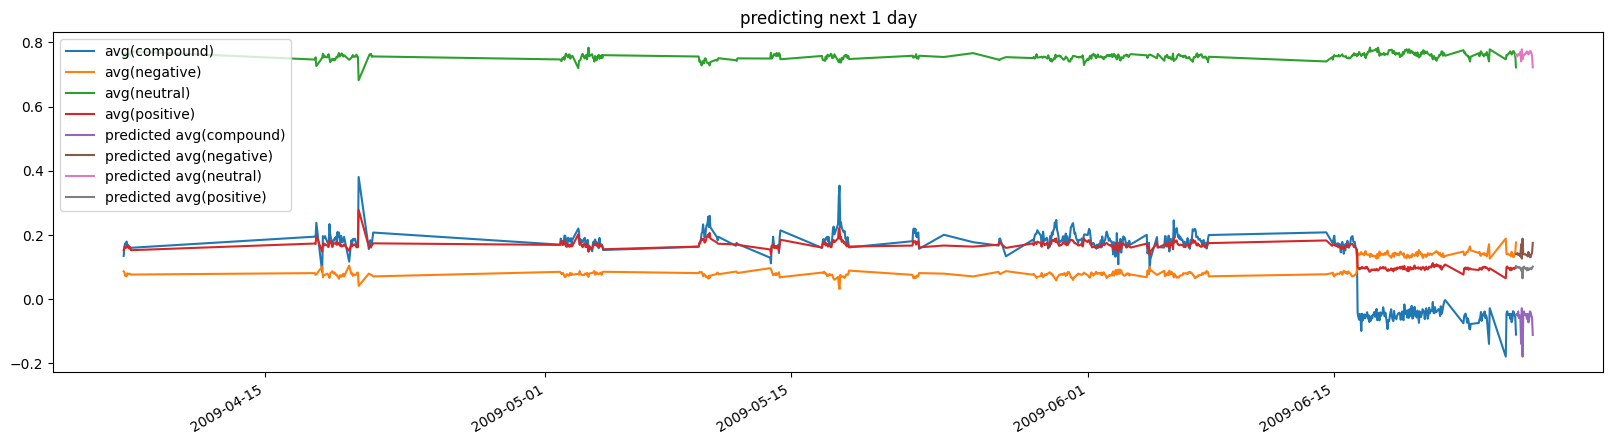

In [182]:
prediction1day.plot(figsize= (20, 5), title= 'predicting next 1 day')

<Axes: title={'center': 'predicting next 3 days'}>

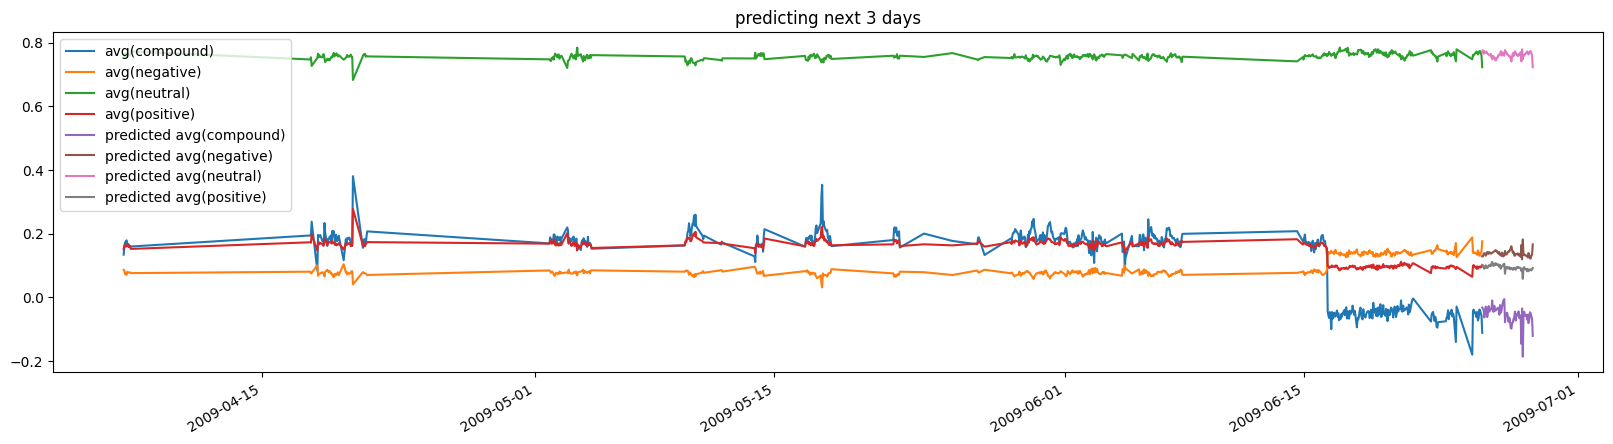

In [183]:
prediction3day.plot(figsize= (20, 5), title= 'predicting next 3 days')

<Axes: title={'center': 'predicting next 7 days'}>

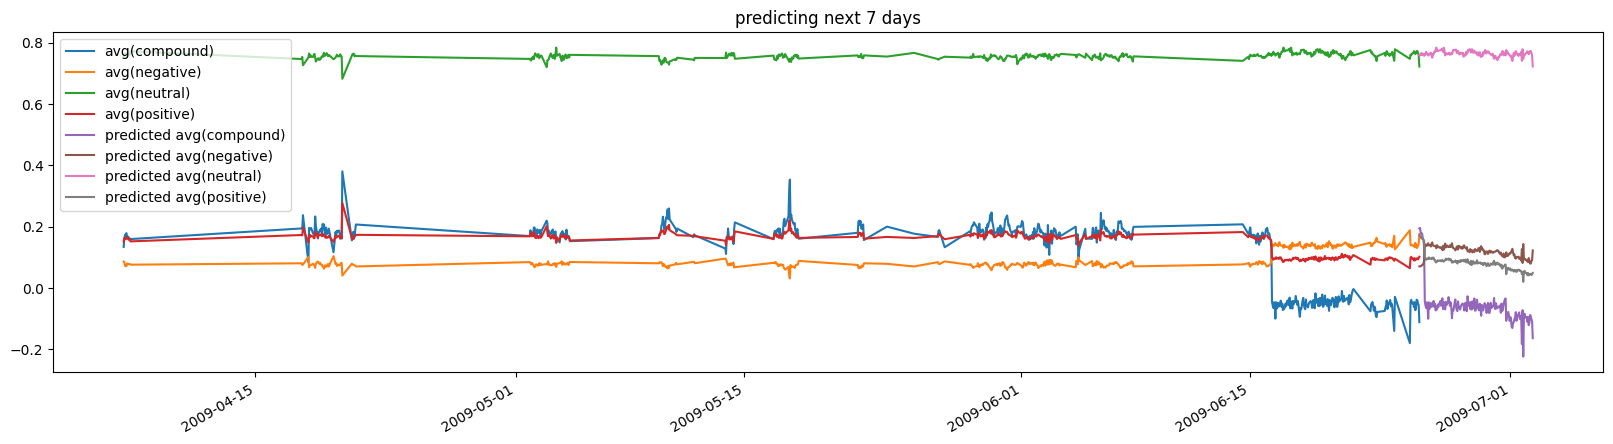

In [184]:
prediction7day.plot(figsize= (20, 5), title= 'predicting next 7 days')

# saving the data

In [164]:
! mkdir ./data
prediction1day.to_csv('./data/1-day-sentiment-prediction.csv')
prediction3day.to_csv('./data/3-day-sentiment-prediction.csv')
prediction7day.to_csv('./data/7-day-sentiment-prediction.csv')

# Starting the dashboard app

In [ ]:
! streamlit run dashboard.py